Facebook Prophet 모듈 이용 Covid19 확진자 추세 예측

In [1]:
import pandas as pd
import plotly.graph_objs as go       # 인터렉티브한 그래프 그리기
import plotly.offline as py    
from fbprophet import Prophet        # 시계열 예측
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import matplotlib.pyplot as plt

import numpy as np

# Load Dataset

In [2]:
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Data Set의 구조 파악
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,156071,156124,156166,156196,156210,156250,156284,156307,156323,156363,156392,156397,156397,156397,156397,156414,156456,156487,156510,156552,156610,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144,157171,157190,157218,157260,157289,157359,157387,157412,157431
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,182610,183282,183873,184340,184887,185300,185497,186222,186793,187363,187994,187994,189125,189355,190125,190815,191440,192013,192600,193075,193269,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292,198732,199137,199555,199750,199945,200173,200639,201045,201402
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,205990,206069,206160,206270,206358,206452,206566,206649,206754,206878,206995,207079,207156,207254,207385,207509,207624,207764,207873,207970,208104,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624,209817,209980,210152,210344,210531,210723,210921,211112,211297
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15425,15462,15505,15516,15516,15516,15516,15516,15572,15618,15618,15618,15618,15705,15717,15744,15744,15819,15819,15819,15907,15929,15972,16035,16086,16086,16086,16299,16342,16426,16566,16712,16712,16712,16712,17115,17426,17658,18010,18010
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64033,64126,64226,64301,64374,64433,64458,64487,64533,64583,64612,64654,64674,64724,64762,64815,64857,64875,64899,64913,64913,64940,64968,64985,64997,65011,65024,65033,65061,65080,65105,65130,65139,65144,65155,65168,65183,65208,65223,65244


# Make it Simple

In [3]:
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South'] # 오늘까지의 배열
df_korea_past = data[data['Country/Region'] == 'Korea, South'] 

df_korea = df_korea.T[5:]  # 날짜만 뽑아냄
df_korea_past = df_korea_past.T[4:-1]  # Today -1 배열

df_korea = df_korea.reset_index().rename(columns={'index': 'date', 160: 'confirmed'})
df_korea_past = df_korea_past.reset_index().rename(columns={'index': 'date', 160: 'confirmed'})

df_korea_past.tail()

,date,confirmed
677,11/29/21,447230
678,11/30/21,452350
679,12/1/21,457612
680,12/2/21,457612
681,12/3/21,467907


# Plot

In [4]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed - df_korea_past.confirmed,
        name='Confirmed in Korea'
    )
)
df_korea.confirmed = df_korea.confirmed - df_korea_past.confirmed # 1일 추가확진자 = 오늘 누적확진자수 - 어제 누적확진자수
fig

# Facebook Prophet

In [14]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'  # 예측하고싶은 값 
})
df_prophet.tail()

,ds,y
677,11/30/21,5120
678,12/1/21,5262
679,12/2/21,0
680,12/3/21,10295
681,12/4/21,5127


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [6]:
m = Prophet(
    changepoint_prior_scale=0.5, # 값이 커질수록 모델이 유연해짐
    changepoint_range=0.98, # 앞부분의 얼만큼을 볼 지 변화점
    yearly_seasonality=False, # 연별, 주별, 일별 트랜드 분석
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=30)  # 30일간의 데이터 예측
forecast = m.predict(future) 

fig = plot_plotly(m, forecast)
py.iplot(fig)

In [7]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.7 MB/s 


In [8]:
!pip install cufflinks

In [9]:
import numpy as np
import chart_studio
chart_studio.tools.set_credentials_file(username='username',api_key='api_key')
import plotly.graph_objects as go

In [10]:
fig.write_html("file.html")
fig.show()
from google.colab import files

# 그래프 html 다운로드
files.download('file.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot changepoints

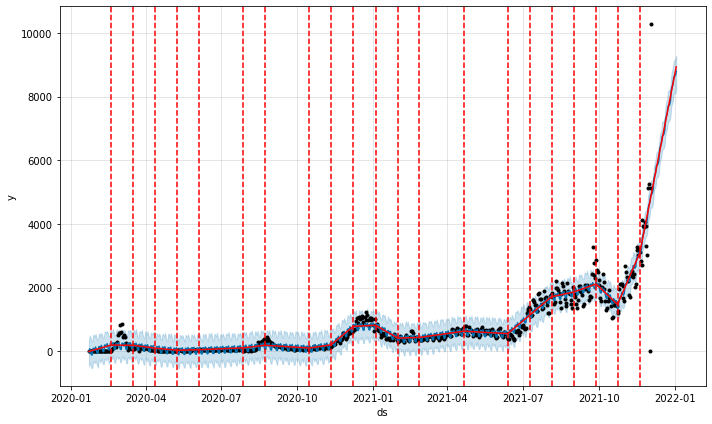

In [11]:
# display changepoints as red dotted line on the plot.
# 변화점 확인
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)